# Get Code with API

In [2]:
import requests
import pandas as pd
from pathlib import Path

# Create data directory if not exists
Path("data").mkdir(exist_ok=True)

violations_url = "https://data.cityofchicago.org/api/views/22u3-xenr/rows.csv"
permits_url = "https://data.cityofchicago.org/api/views/ydr8-5enu/rows.csv"

params = {"$limit": 10000}

violations_response = requests.get(violations_url, params=params)
violations_path = Path("data/violations.csv")
with open(violations_path, "wb") as f:
    f.write(violations_response.content)

permits_response = requests.get(permits_url, params=params)
permits_path = Path("data/permits.csv")
with open(permits_path, "wb") as f:
    f.write(permits_response.content)

violations_df = pd.read_csv(violations_path)
permits_df = pd.read_csv(permits_path)

print("Violations shape:", violations_df.shape)
print("Permits shape:", permits_df.shape)


C:\Users\sophi\AppData\Local\Temp\ipykernel_13432\1715409381.py:29: DtypeWarning: Columns (0,1,12,14,35,40,45,50,55,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,107) have mixed types. Specify dtype option on import or set low_memory=False.
  permits_df = pd.read_csv(permits_path)


Violations shape: (1983714, 26)
Permits shape: (821467, 116)


# Get Code with Socrata

In [ ]:
from sodapy import Socrata
import pandas as pd

client = Socrata("data.cityofchicago.org", app_token="5ah8bJgzgJRVbFDfj4VUGVz0s")

violations_results = client.get(
    "22u3-xenr",
    where="inspection_category='PERMIT'",
    limit=50000 
)

violations_df = pd.DataFrame.from_records(violations_results)
print("Violations loaded:", violations_df.shape)

permits_results = client.get(
    "ydr8-5enu",
    limit=50000
)

permits_df = pd.DataFrame.from_records(permits_results)
print("Permits loaded:", permits_df.shape)

violations_df.columns = violations_df.columns.str.lower().str.strip().str.replace(" ", "_")
permits_df.columns = permits_df.columns.str.lower().str.strip().str.replace(" ", "_")
violations_df["violation_date"] = pd.to_datetime(violations_df["violation_date"], errors="coerce")
permits_df["issue_date"] = pd.to_datetime(permits_df["issue_date"], errors="coerce")

violations_df["year"] = violations_df["violation_date"].dt.year
permits_df["year"] = permits_df["issue_date"].dt.year

violations_df = violations_df[violations_df["year"] >= 2015]
permits_df = permits_df[permits_df["year"] >= 2015]


for col in ["latitude", "longitude", "community_area"]:
    if col in permits_df.columns:
        permits_df[col] = pd.to_numeric(permits_df[col], errors="coerce")
    if col in violations_df.columns:
        violations_df[col] = pd.to_numeric(violations_df[col], errors="coerce")

permits_summary = (
    permits_df.groupby("year")
    .size()
    .reset_index(name="num_permits")
)

violations_summary = (
    violations_df.groupby("year")
    .size()
    .reset_index(name="num_violations")
)

merged_df = pd.merge(permits_summary, violations_summary, on="year", how="inner")
print("\nMerged data (first few rows):")
print(merged_df.head())


Violations loaded: (50000, 26)
Permits loaded: (50000, 112)

Merged data (first few rows):
   year  num_permits  num_violations
0  2015          994            8518
1  2016         1029            8310
2  2017         1085            1676
3  2018         1162             363
4  2019         1042             394

All data saved and ready for visualization or correlation.


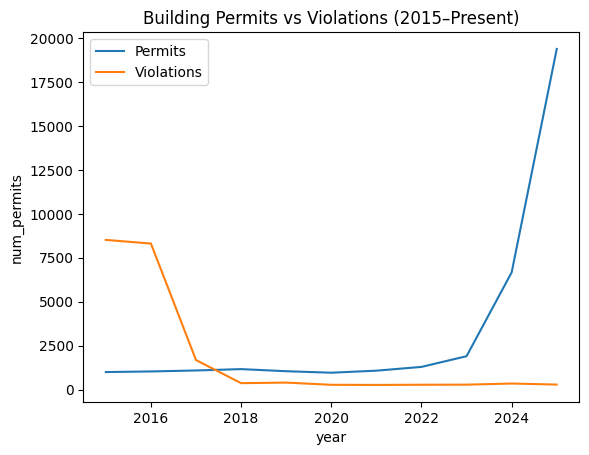

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=merged_df, x="year", y="num_permits", label="Permits")
sns.lineplot(data=merged_df, x="year", y="num_violations", label="Violations")
plt.title("Building Permits vs Violations (2015–Present)")
plt.show()


In [4]:
merged_df[['num_permits','num_violations']].corr()


,num_permits,num_violations
num_permits,1.000000,-0.225875
num_violations,-0.225875,1.000000
